In [1]:
from __future__ import absolute_import

#check if there is an evirronment variable called ROOT_PATH
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

# import local_settings
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from dsp_utils import parse_samples

from runners import Runner
from custom_optimizers import ElementWiseDecay, GlobalPNormDecay

In [23]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 400
TfN2 = 300

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

playlist_ab = {
'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
     }

playlist = {
# 'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
# 'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
# 'savings': 2 * [(P0, TsA), (Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': [(P0, TsA), (Pplus, TsA),(P0, 2000),(Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 140)],
'evrecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 2),
               (Pplus, 2),
               (Pchannel, 140)],
# 'spOVRrecovery': [(P0, 50),
#                (Pplus, 450),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'spOVRrecovery_ref': [(P0, 50),
#                (Pplus, 150),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 384),
#                (Pchannel, 400)],    
# 'ANB0':[(P0, TaN),(Pminus, TaB)],
# 'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
# 'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
# 'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

# playlist.update(playlist_ab)

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [3]:
# frog_playlist = {
# f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

# frog_playlist_a = {
# f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

# frog_playlist.update(frog_playlist_a)

In [4]:
test_vec= np.stack([np.zeros(200),
                    np.zeros(200),
                    np.zeros(200),
                   np.linspace(2*Pminus,2*Pplus,200)]).T

x_test = test_vec[:,-1]


In [5]:
cnt =0

results = {}
swarg2s =  [1e-4,3e-4] #[0.05,0.1,0.2,0.5,1,2]
swarg1s = [4e-1, 1e0] #, 0.3] #[0, 0.2, 0.5]
for i1, swarg1 in enumerate(swarg1s):
    for i2, swarg2 in enumerate(swarg2s):
        lr = swarg2
        b_high = 0.3
        alpha = swarg1
        beta = None
        model_construct_args =  dict(n_inputs = 4,
                          n_hidden = 2*512,
                          n_outs = 1,
                          en_bias = False,
                         b_high=b_high, first_layer_init='uniform_unity',
                        first_layer_weights_trainable = True,
                        out_layer_init='zeros',
                        post_activation_bias = None,
                        post_activation_bias_scale = 0,
                          nl = 'relu', skip_gain= 0)
        setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':lr, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True, 
                   'optimizer_class': GlobalPNormDecay, 'optimizer_opts': dict(alpha=alpha)}
        runner = Runner(model_construct_args=model_construct_args,
                        test_vec=test_vec,
                        **setting)
        results[(i1,i2)] = runner.run_multiple(playlist_ab)

running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3
running scenario: AB0
running scenario: AB1
running scenario: AB2
running scenario: AB3


In [29]:
def do_plots(results,playlist,figsize=(18, 6), slope=1.0):
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.ylim([1.5*Pminus,1.5*Pplus])


    plt.subplot(1,3,2)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    plt.ylim([1.5*Pminus,1.5*Pplus])


    plt.subplot(1,3,3)
    
    times = [1, 170, 185]
    colors = ['tab:red','tab:blue','tab:orange','tab:green']
    paradigm = 'sprecovery'
    plt.plot(x_test*slope,x_test,'k:')
    for i,time in enumerate(times):
        u_test = results[paradigm].test_output[time]
        plt.plot(x_test,u_test,colors[i])
        u_t = results[paradigm].u_lp[time]
        plt.plot(u_t, u_test[np.argmin(np.abs(x_test-u_t))],'*',color=colors[i])
    plt.ylim([1.5*Pminus,1.5*Pplus])


    # for t in [170,185]:
    #     plt.plot(results['sprecovery'].test_output[t])
    # plt.show()

In [30]:
def do_plots_full(results,playlist,figsize=(24, 12)):
    plt.figure(figsize=figsize)
    plt.subplot(2,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.ylim([1.5*Pminus,1.5*Pplus])
    plt.subplot(2,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.0])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(2,3,3)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,4)
    plot_by_key(results,
                ['spOVRrecovery','spOVRrecovery_ref'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )


    # plt.subplot(2,3,5)
    # plot_by_key(results, ['frogs_long','anti_frogs_long'],visu_offsets = [0, 0.0])
    # plt.xlabel('epochs')
    # plt.ylabel('u(epoch) [au]')

    plt.subplot(2,3,5)
    plot_by_key(results,
                ['AB0','AB1','AB2','AB3'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    # plt.subplot(2,3,5)
    # plot_by_key(results,
    #             ['ANB0','ANB1','ANB2','ANB3'],
    #             colors=['tab:red','tab:blue','tab:orange','tab:green'],
    #             align_end=True,
    #             visu_offsets=[0]*10,
    #            )
    
    plt.subplot(2,3,6)
    for iz, z in enumerate(hrz_params['z_list']):
        deltas = []
        scenario = f'herzfeld,z={z}'
        this_result = results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')
    plt.legend(loc='upper right')
    plt.xlabel('block #')
    plt.ylabel('adaptation delta channel2-channel1')

In [8]:
def compute_herzfeld_probes(result,paradigm_data,hrz_params):
    deltas = []
    this_result = result
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = paradigm_data[bb][-1]
        pointer += block_length
        deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3]) 
    return deltas           


In [9]:
def plot_stimulus(paradigm_stimulus):
    plt.figure()
    
    for i,stimulus in enumerate(paradigm_stimulus):
        plt.plot(stimulus,label=f'stimulus {i}')
    plt.legend(loc='upper right')
    plt.xlabel('time')
    plt.ylabel('stimulus [au]')

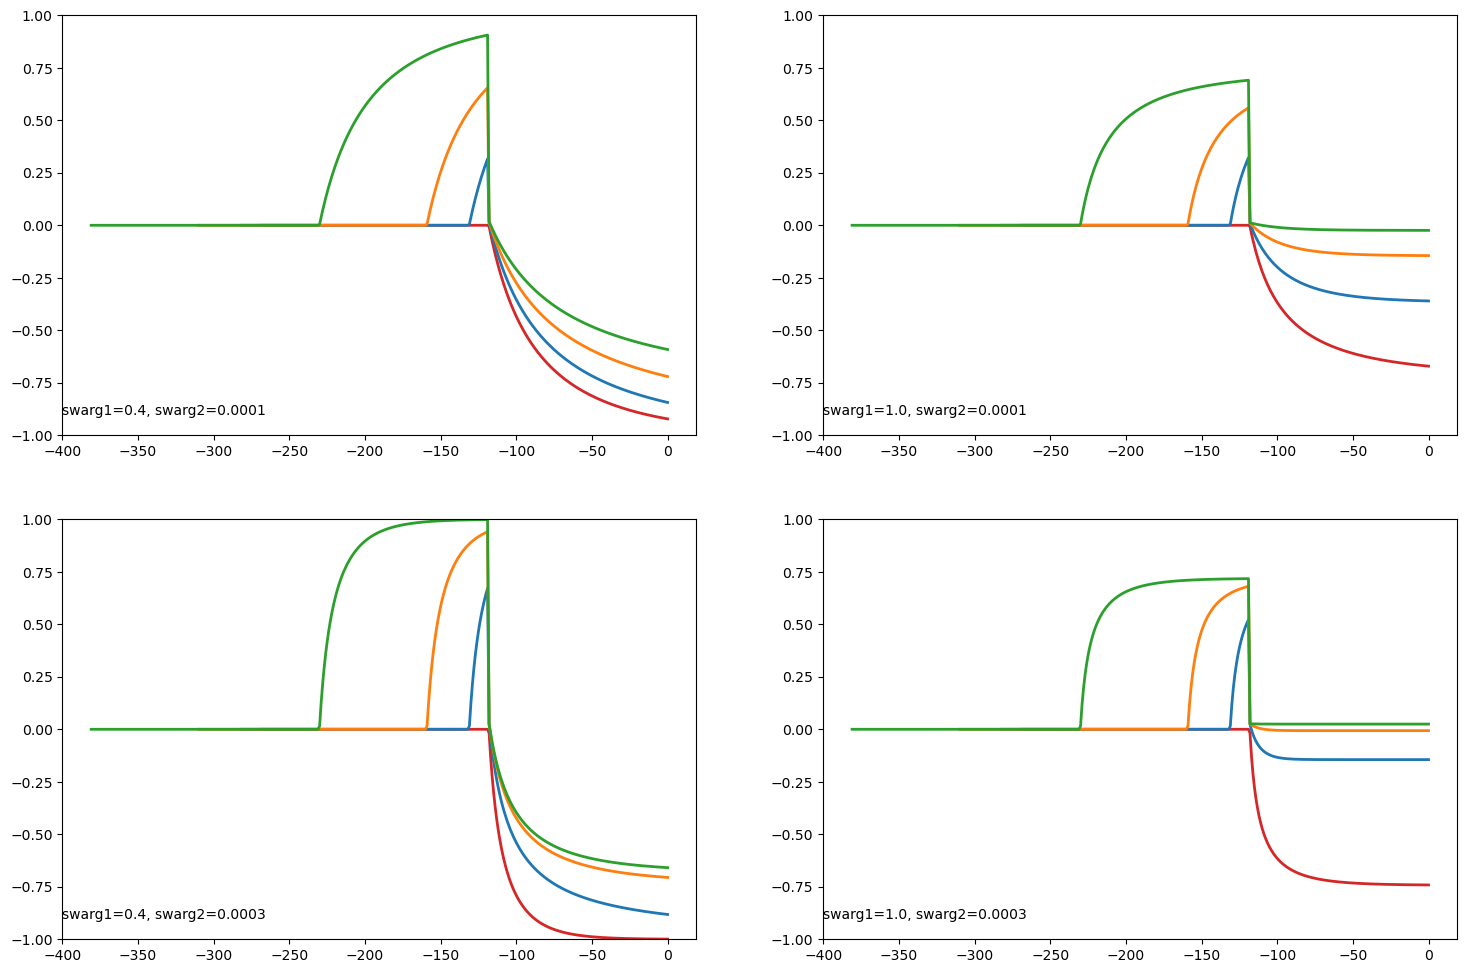

In [10]:
plt.figure(figsize=(18, 12))
for i2,swarg2 in enumerate(swarg2s):
    for i1,swarg1 in enumerate(swarg1s):
        item = (i1,i2)
        plt.subplot(len(swarg2s),len(swarg1s),i1+1+i2*len(swarg1s))
        plot_by_key(results[item],
                ['AB0','AB1','AB2','AB3'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
                )
        plt.ylim([-1,1])
        plt.text(-400, -0.9, f'swarg1={swarg1}, swarg2={swarg2}',)

In [16]:
antesettings = [(0.4,3e-4)]

In [34]:
results_ext = {}
swarg3s = np.arange(0.7,1.1,0.05)
# swarg2s =  [1, 0.8, 0.7, 0.5, 0.4] #[0.05,0.1,0.2,0.5,1,2]
# swarg1s = [1e-1, 1e0, 1e1, 1e2,1e3] #, 0.3] #[0, 0.2, 0.5]
for j_, swarg3 in enumerate(swarg3s):
  for i_, (swarg1,swarg2) in enumerate(antesettings):
          print(f'Running setting {i_} with swarg1={swarg1}, swarg2={swarg2}, swarg3={swarg3}')
          lr = swarg2
          b_high = 0.15
          alpha = swarg1
          beta = None
          model_construct_args =  dict(n_inputs = 4,
                            n_hidden = 2*512,
                            n_outs = 1,
                            en_bias = False,
                          b_high=b_high, first_layer_init='uniform_unity',
                          first_layer_weights_trainable = True,
                          out_layer_init='zeros',
                          post_activation_bias = None,
                          post_activation_bias_scale = 0,
                            nl = 'relu', skip_gain= 0)
          setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':lr, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True, 
                    'optimizer_class': GlobalPNormDecay, 'optimizer_opts': dict(alpha=alpha),
                    'scaling_spec': {'scaling_u_fb': swarg3}}
          runner = Runner(model_construct_args=model_construct_args,
                          test_vec=test_vec,
                          **setting)
          results_ext[(i_,j_)] = runner.run_multiple(playlist)

Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=0.7
running scenario: savings


running scenario: sprecovery
running scenario: evrecovery
Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=0.75
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=0.8
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=0.8500000000000001
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=0.9000000000000001
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=0.9500000000000002
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
Running setting 0 with swarg1=0.4, swarg2=0.0003, swarg3=1.0000000000000002
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
Running set

Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.7
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.75
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.8
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.8500000000000001
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.9000000000000001
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.9500000000000002
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.0000000000000002
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.0500000000000003
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.1000000000000003


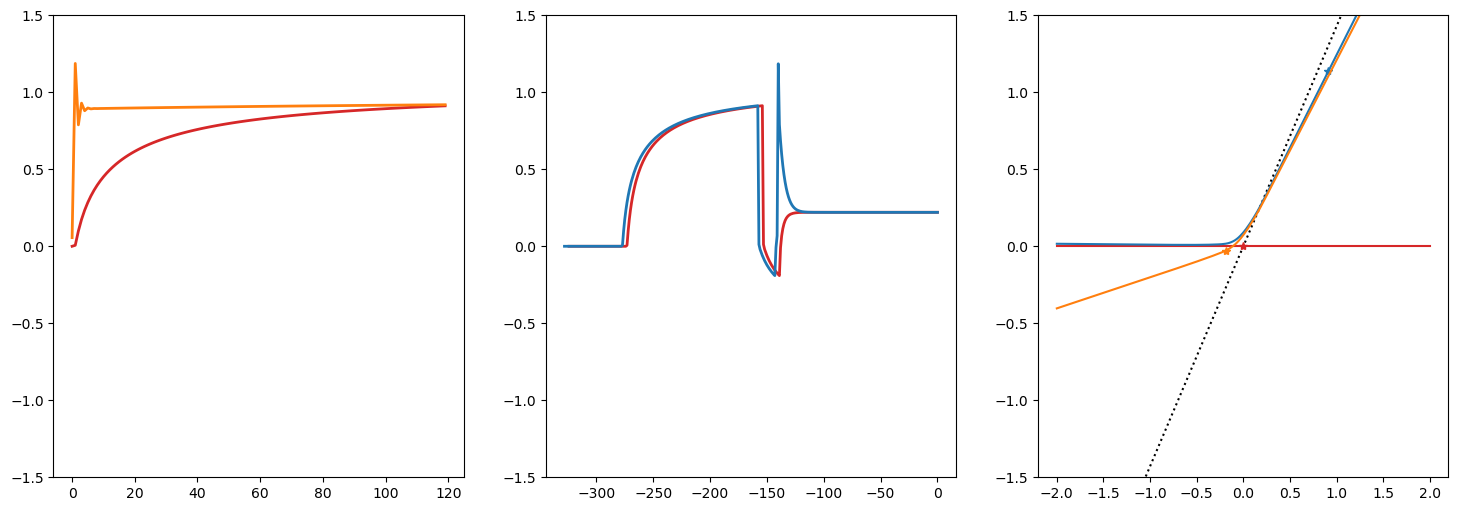

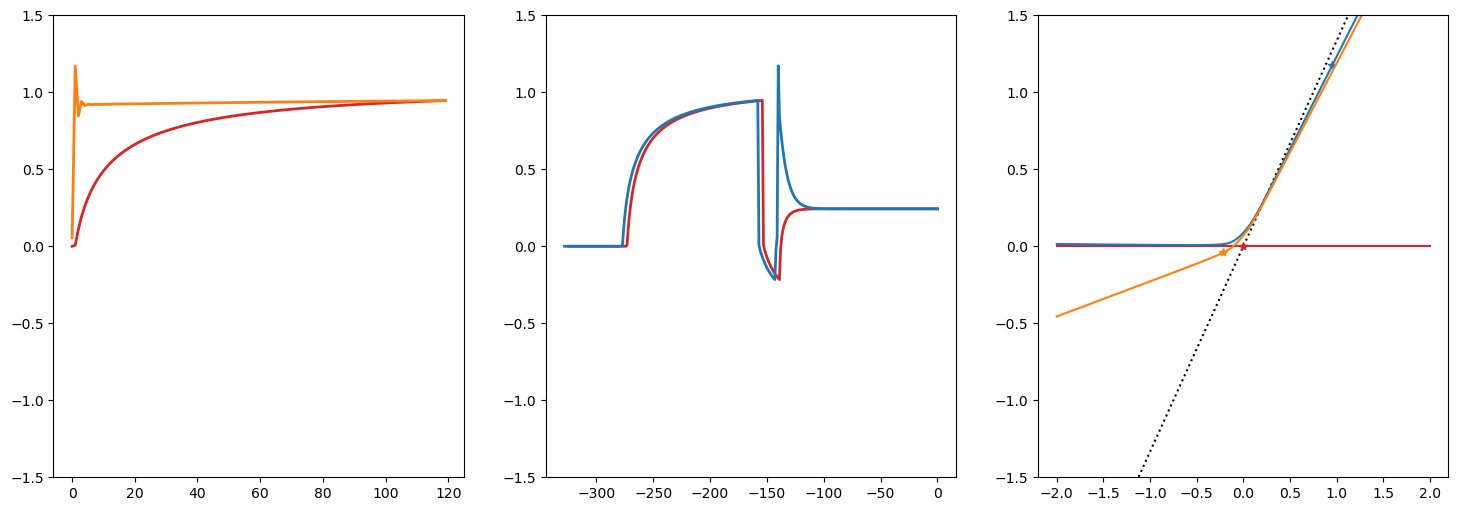

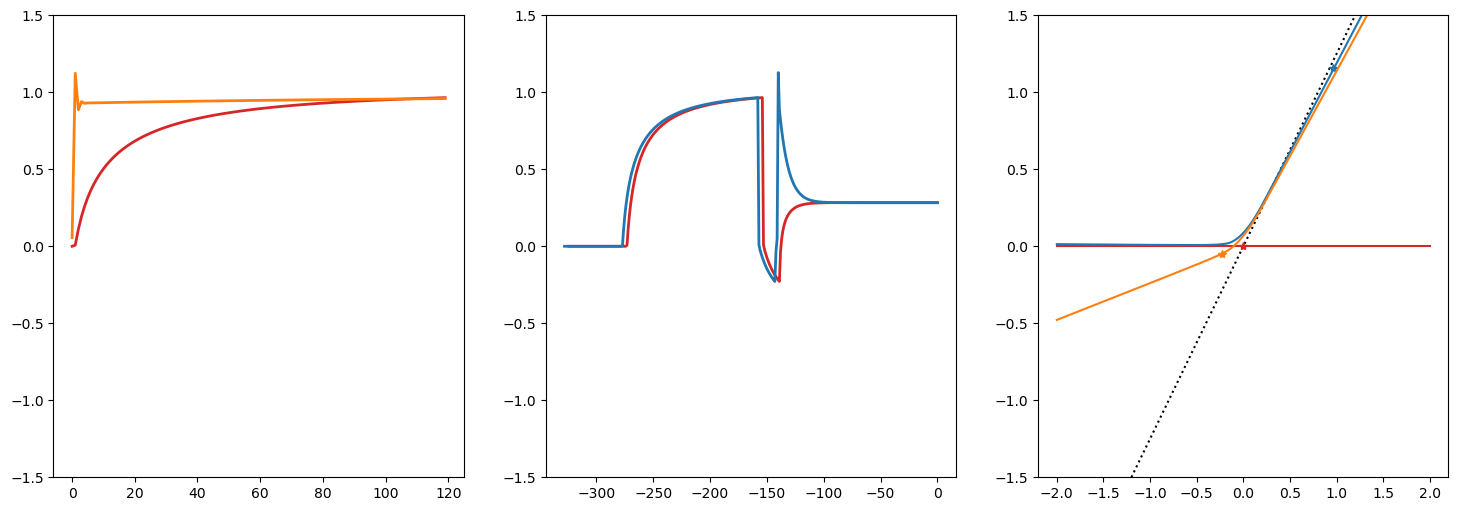

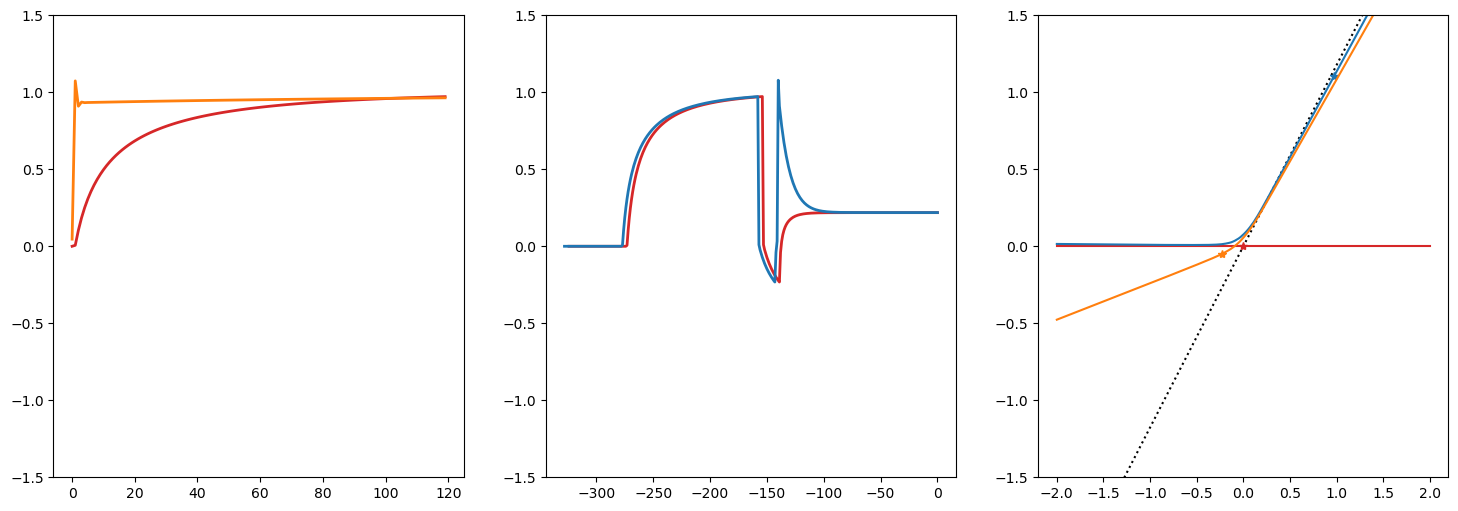

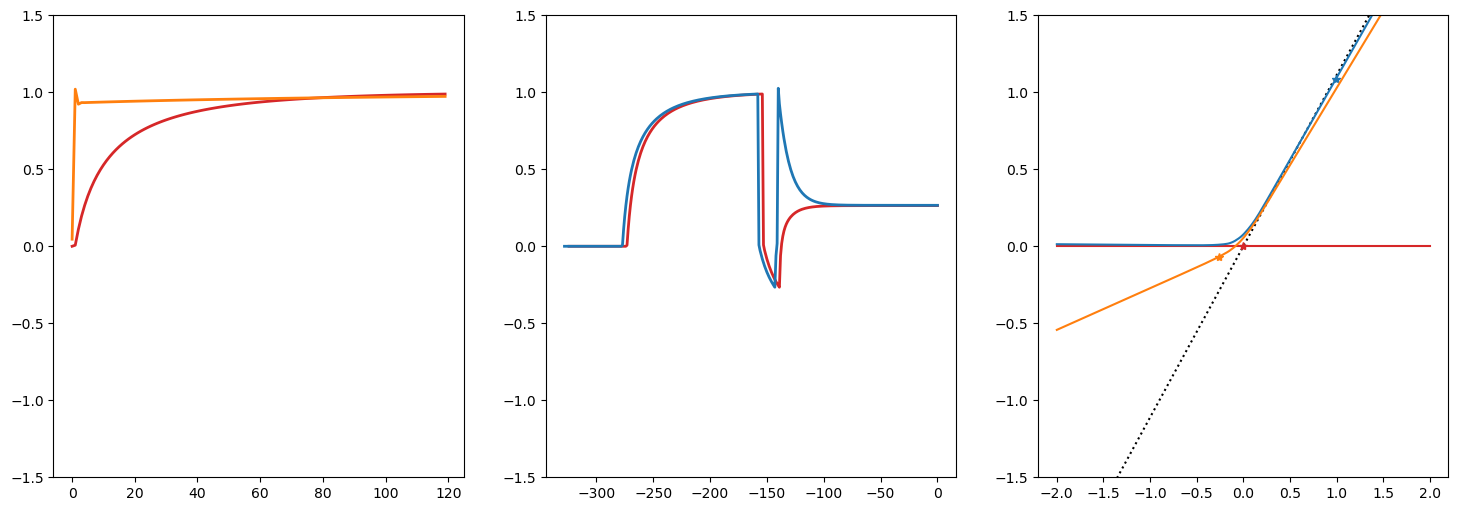

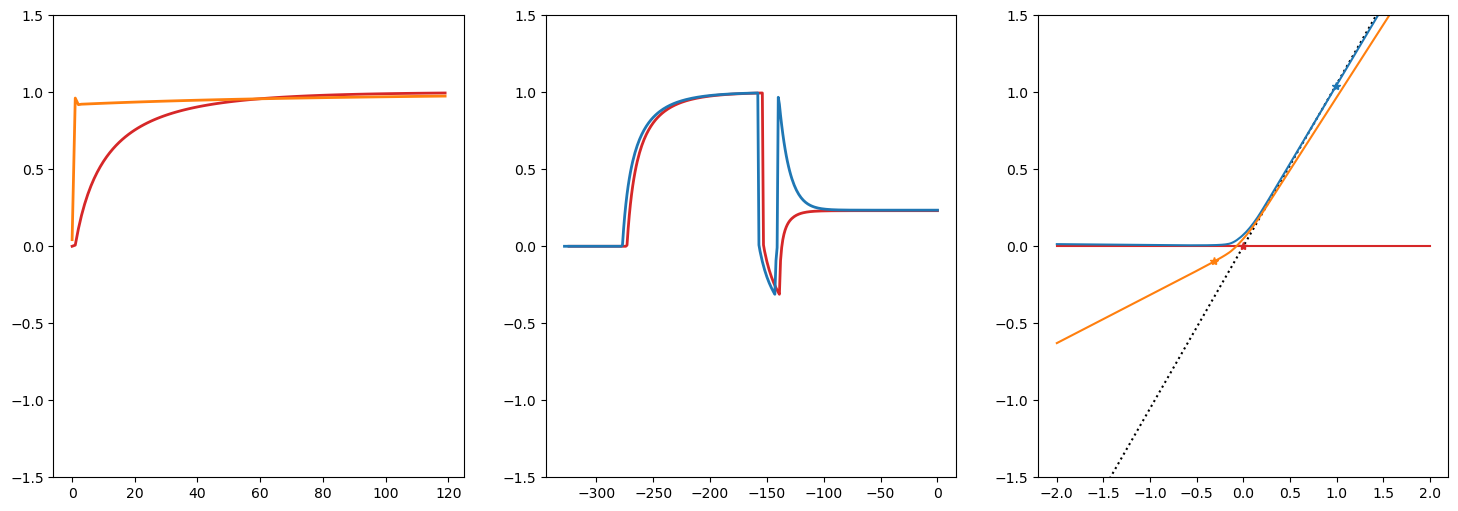

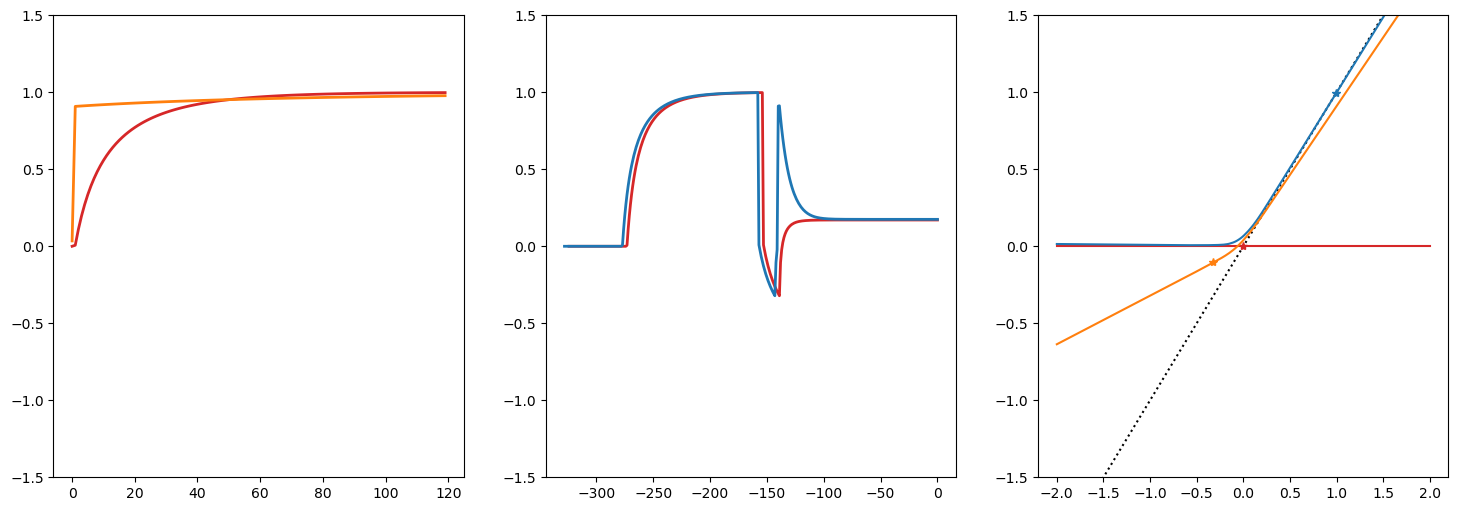

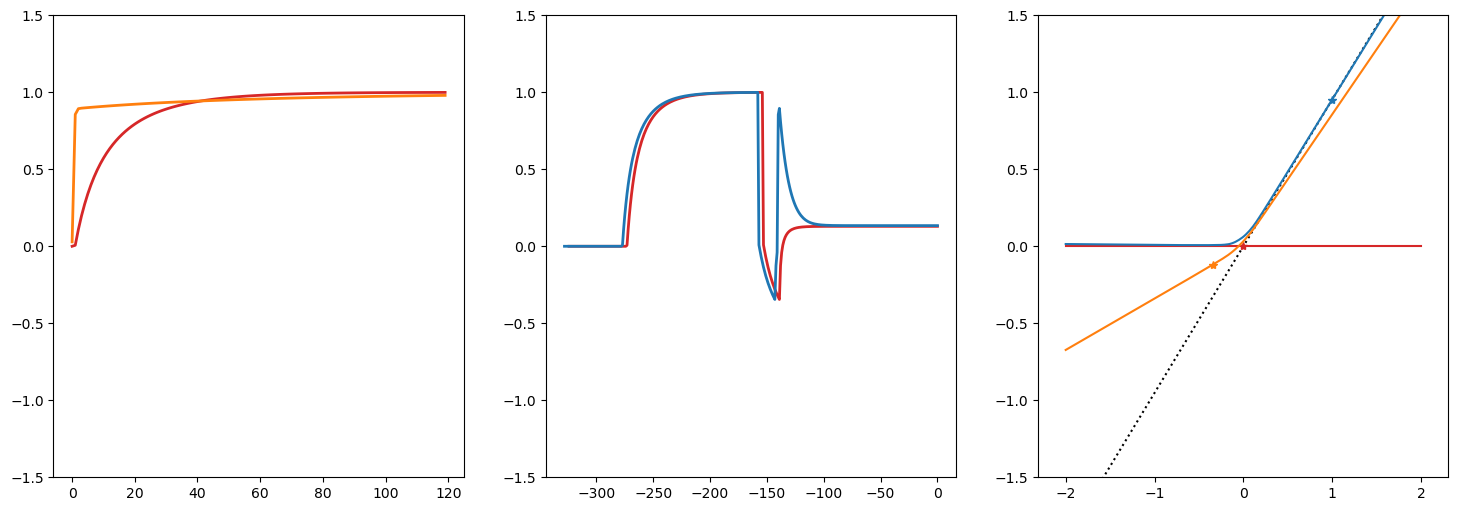

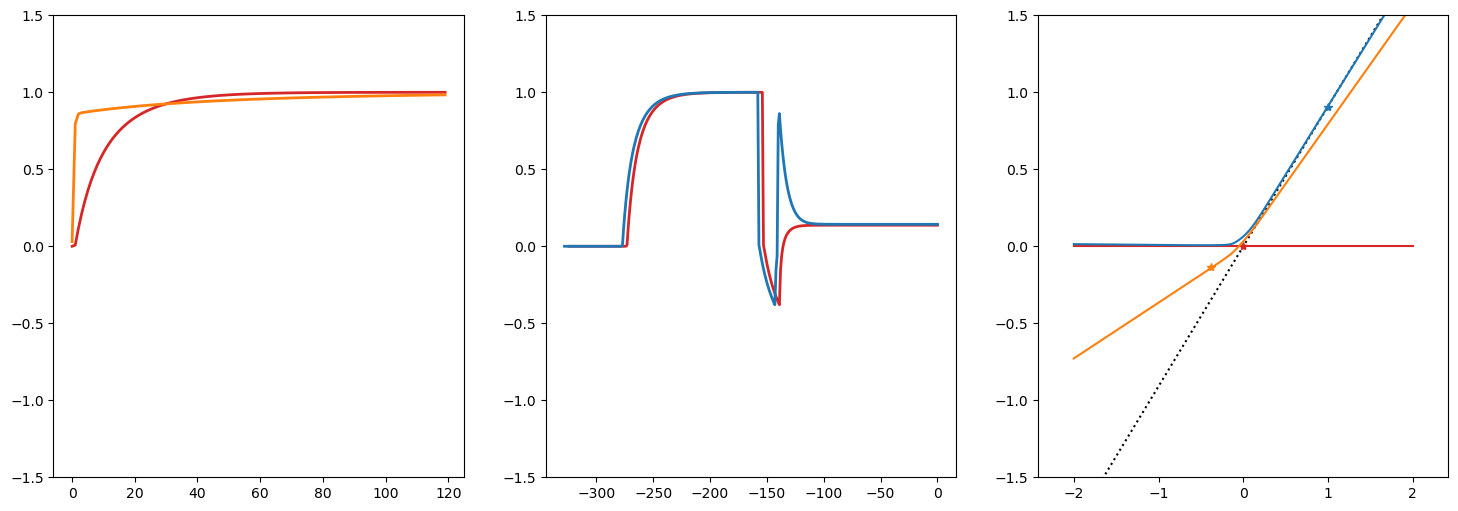

In [35]:
for j_, swarg3 in enumerate(swarg3s):
        for i_, (swarg1,swarg2) in enumerate(antesettings):
                print(f'Plotting results for swarg1={swarg1}, swarg2={swarg2}, swarg3={swarg3}')
                do_plots(results_ext[i_, j_],playlist, slope=swarg3)


Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.7
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.75
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.8
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.8500000000000001
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.9000000000000001
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.9500000000000002
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.0000000000000002
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.0500000000000003
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.1000000000000003


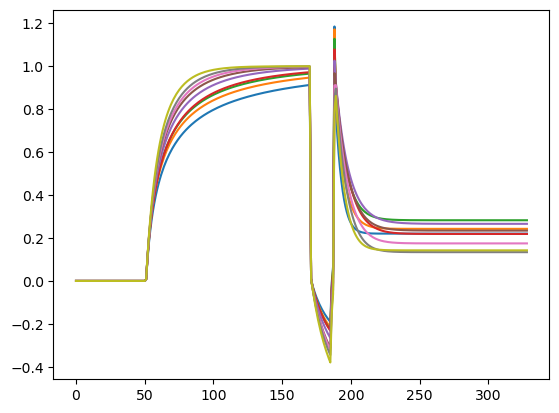

In [37]:
for j_, swarg3 in enumerate(swarg3s):
        for i_, (swarg1,swarg2) in enumerate(antesettings):
                print(f'Plotting results for swarg1={swarg1}, swarg2={swarg2}, swarg3={swarg3}')
                plt.plot(results_ext[i_, j_]['evrecovery'].u_lp)

Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.7
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.75
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.8
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.8500000000000001
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.9000000000000001
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=0.9500000000000002
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.0000000000000002
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.0500000000000003
Plotting results for swarg1=0.4, swarg2=0.0003, swarg3=1.1000000000000003


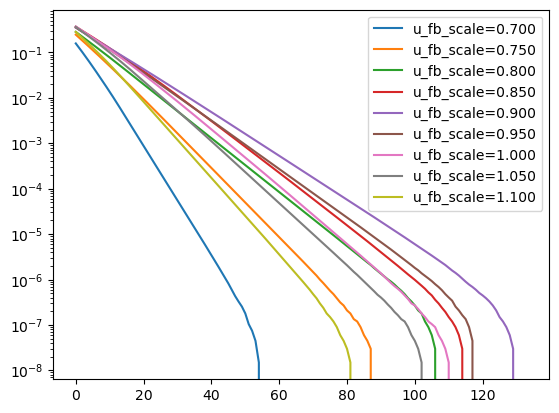

In [45]:
for j_, swarg3 in enumerate(swarg3s):
        for i_, (swarg1,swarg2) in enumerate(antesettings):
                print(f'Plotting results for swarg1={swarg1}, swarg2={swarg2}, swarg3={swarg3}')
                u = results_ext[i_, j_]['evrecovery'].u_lp
                plt.semilogy(u[-134:]-u[-1],label=f'u_fb_scale={swarg3:.3f}')
plt.legend(loc='upper right')

Plotting results for swarg1=1, swarg2=0.0001
Plotting results for swarg1=0.4, swarg2=0.0003
Plotting results for swarg1=0.4, swarg2=0.0001


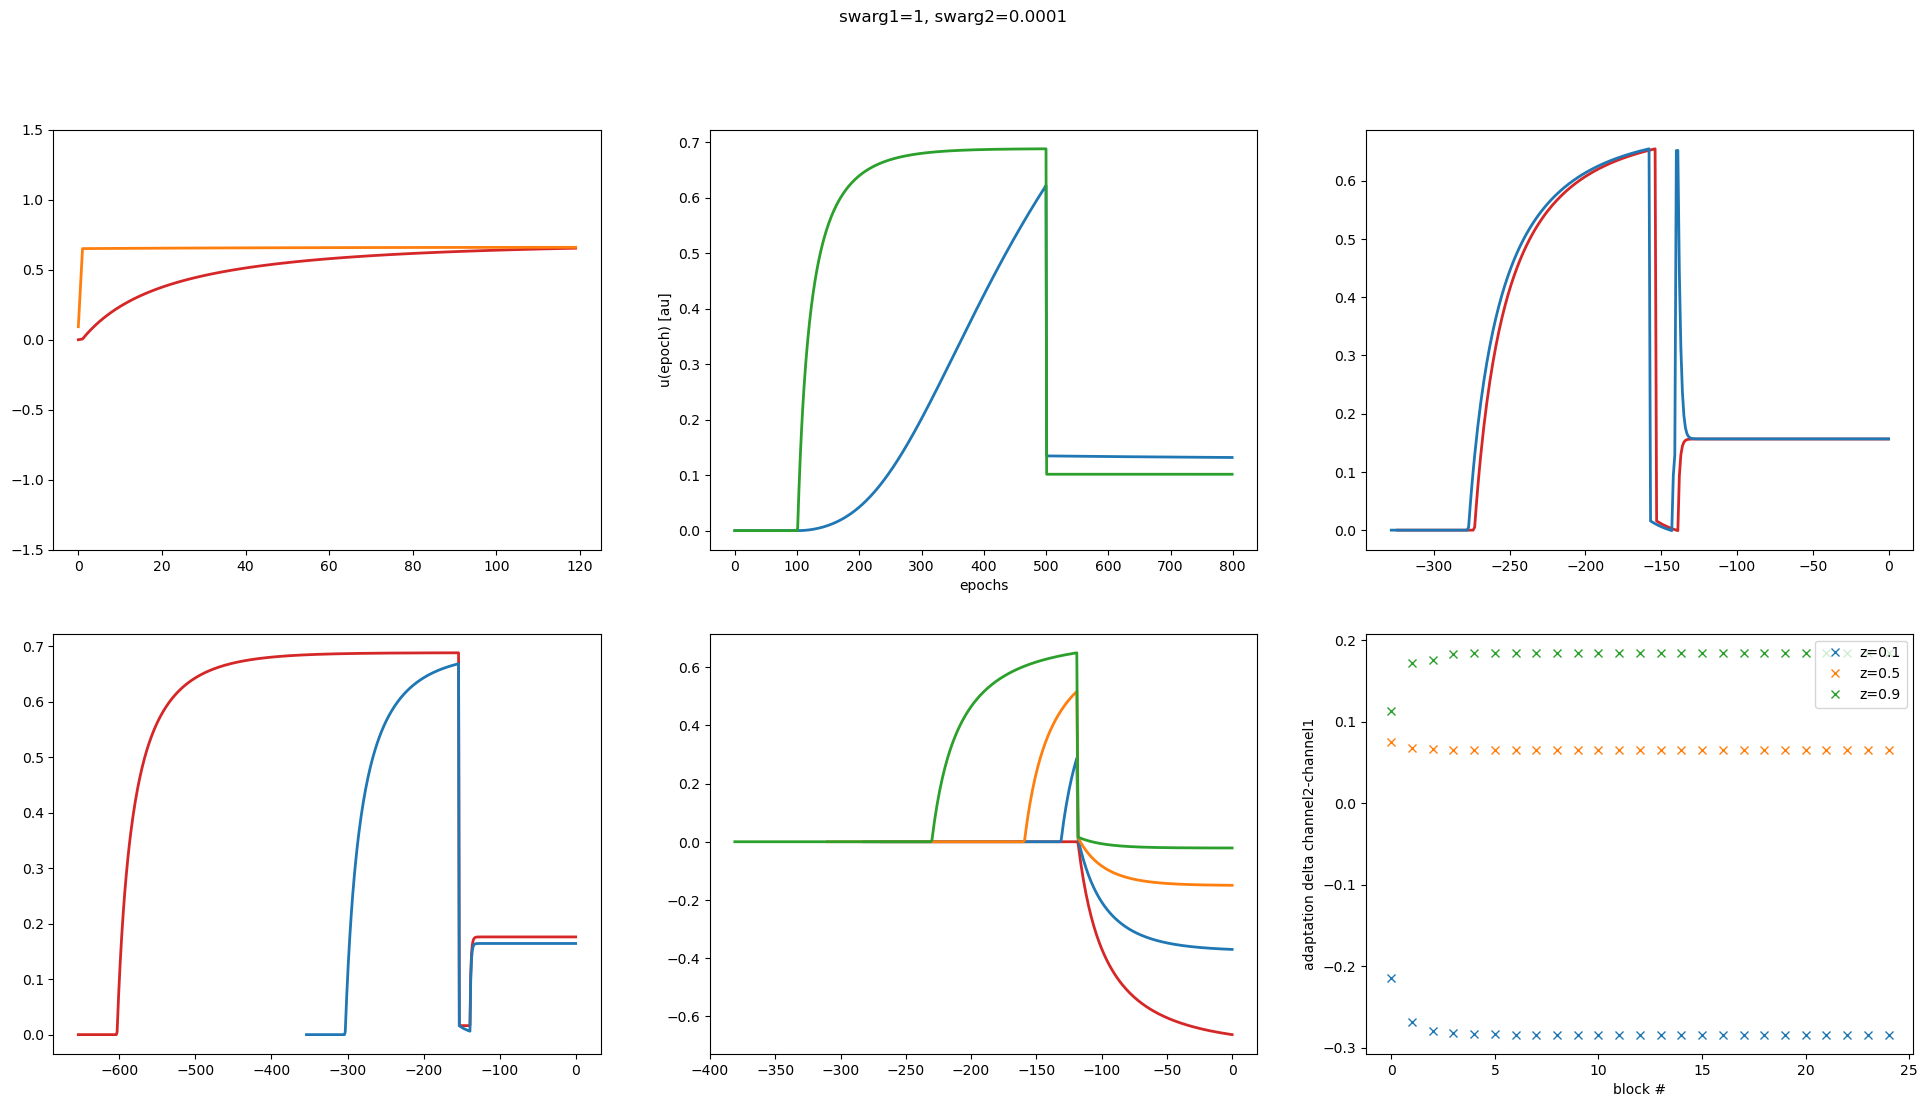

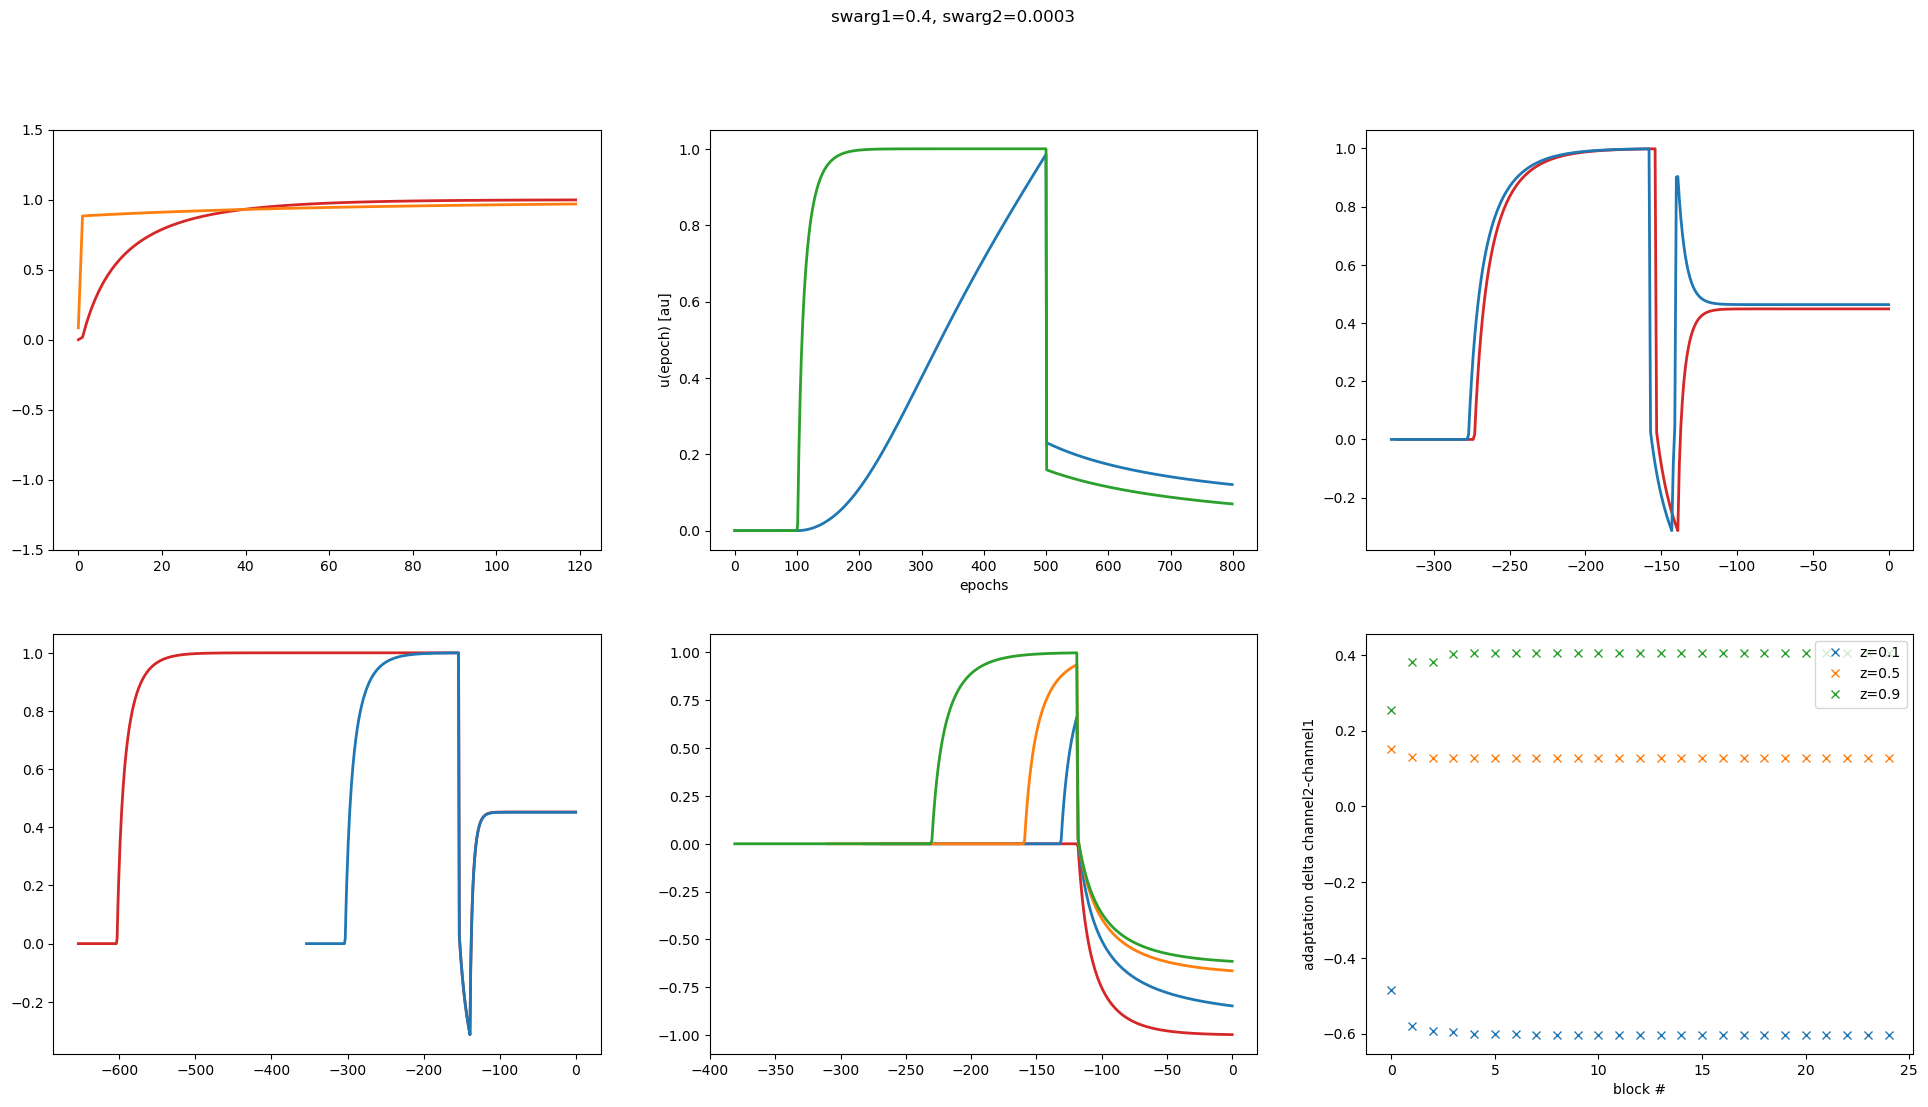

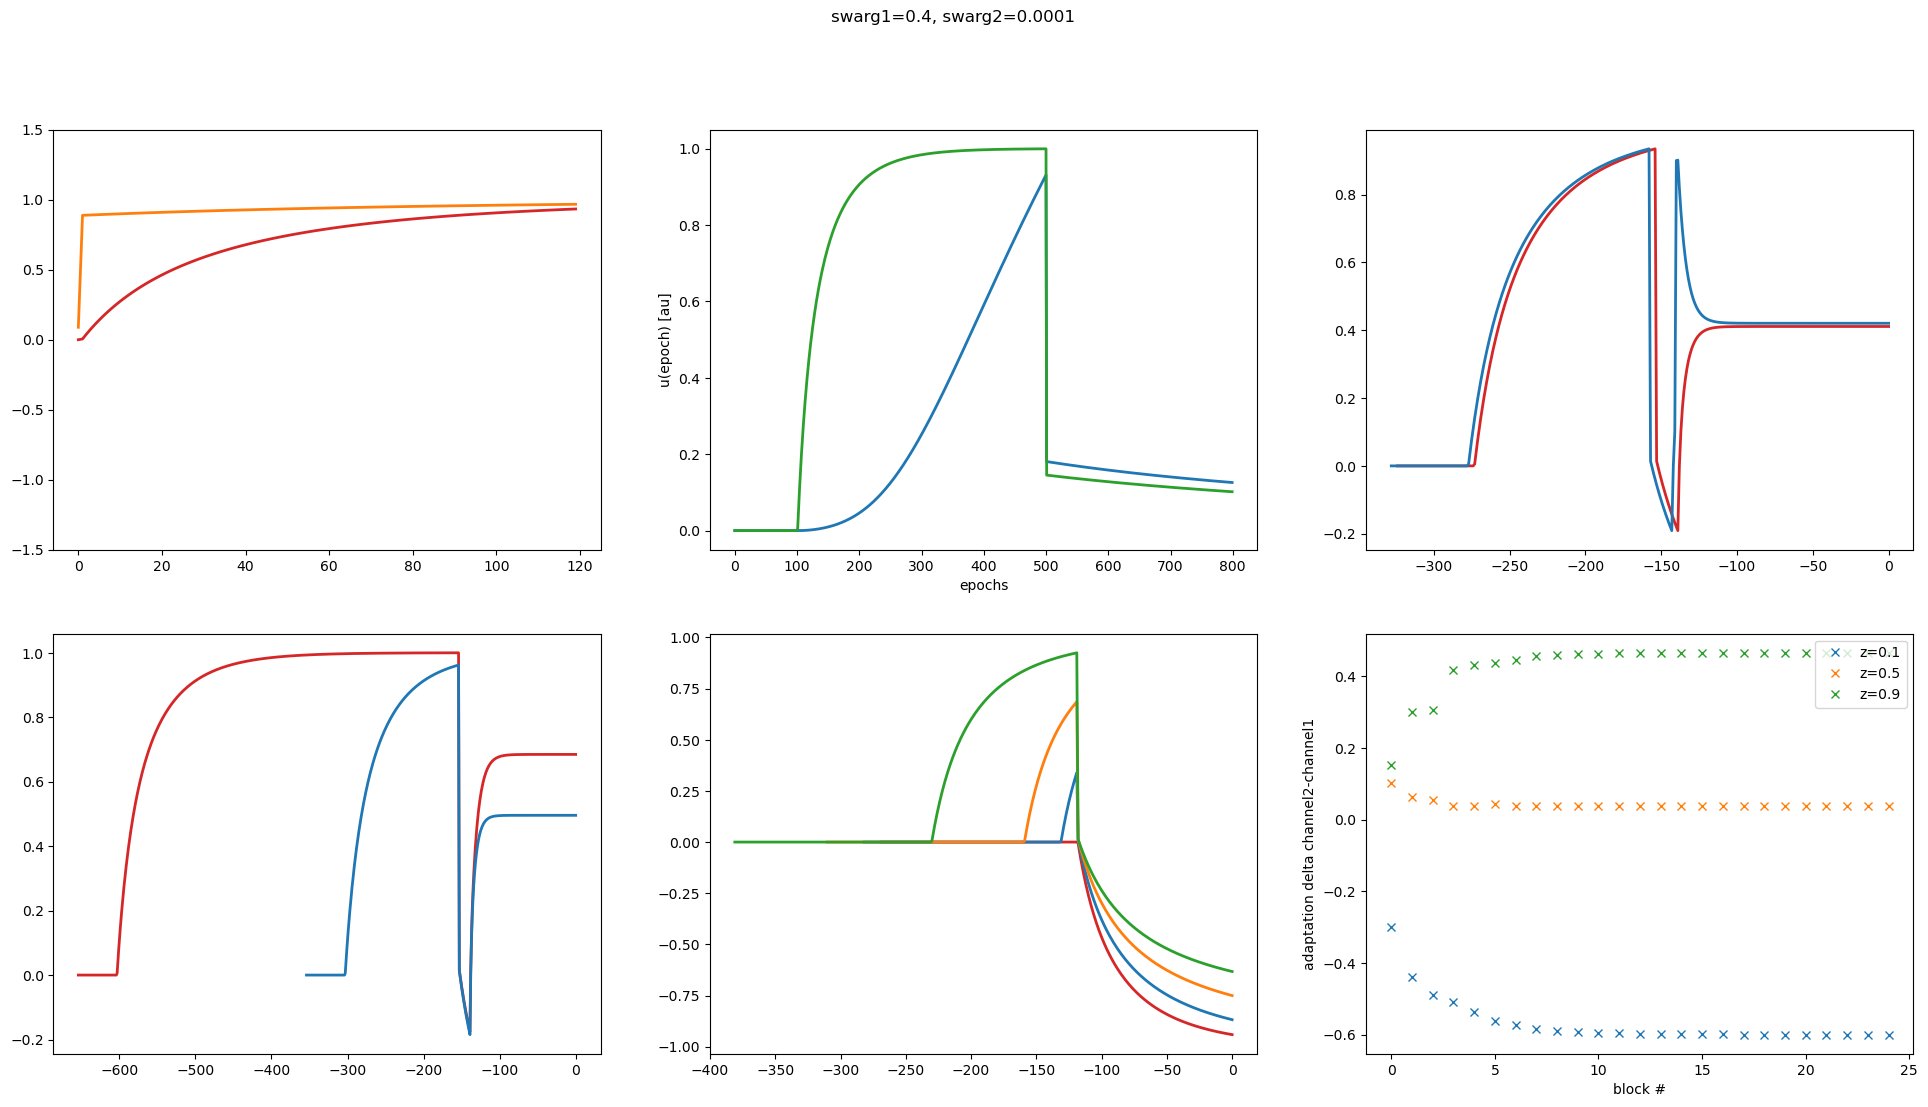

In [ ]:
for i_, (swarg1,swarg2) in enumerate(antesettings):
        print(f'Plotting results for swarg1={swarg1}, swarg2={swarg2}')
        do_plots_full(results_ext[i_],playlist)
        plt.suptitle(f'swarg1={swarg1}, swarg2={swarg2}')
